# P-219 => Hourly Energy Consumption Forecast

    The hourly power consumption data comes from PJM's website and are in megawatts (MW).

    ● Build model, split the last year into a test set and train model on remaining data.
    ● Forecast for next 30 days using model build.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 200
sns.set_style('darkgrid')

In [3]:
# Importing data set
df = pd.read_excel(r"C:\Users\rohit\Downloads\Project\PJMW_MW_Hourly.xlsx", index_col=0, parse_dates=True)
df['Years'] = df.index.year
s = (df.index.month * 100 + df.index.day - 320) % 1300
df['Season'] = pd.cut(s, [0, 300, 600, 900, 1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])
df['Hours'] = df.index.hour
df

,PJMW_MW,Years,Season,Hours
Datetime,,,,
2002-12-31 01:00:00,5077.0,2002,Winter,1
2002-12-31 02:00:00,4939.0,2002,Winter,2
2002-12-31 03:00:00,4885.0,2002,Winter,3
2002-12-31 04:00:00,4857.0,2002,Winter,4
2002-12-31 05:00:00,4930.0,2002,Winter,5
...,...,...,...,...
2018-01-01 20:00:00,8401.0,2018,Winter,20
2018-01-01 21:00:00,8373.0,2018,Winter,21
2018-01-01 22:00:00,8238.0,2018,Winter,22


## Data preprocessing and EDA

In [4]:
df['Season'].fillna

<bound method Series.fillna of Datetime
2002-12-31 01:00:00    Winter
2002-12-31 02:00:00    Winter
2002-12-31 03:00:00    Winter
2002-12-31 04:00:00    Winter
2002-12-31 05:00:00    Winter
                        ...  
2018-01-01 20:00:00    Winter
2018-01-01 21:00:00    Winter
2018-01-01 22:00:00    Winter
2018-01-01 23:00:00    Winter
2018-01-02 00:00:00    Winter
Name: Season, Length: 143206, dtype: category
Categories (4, object): ['Spring' < 'Summer' < 'Fall' < 'Winter']>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143206 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   PJMW_MW  143206 non-null  float64 
 1   Years    143206 non-null  int64   
 2   Season   142822 non-null  category
 3   Hours    143206 non-null  int64   
dtypes: category(1), float64(1), int64(2)
memory usage: 4.5 MB


In [6]:
df.describe(include='all')

,PJMW_MW,Years,Season,Hours
count,143206.000000,143206.000000,142822,143206.000000
unique,NaN,NaN,4,NaN
top,NaN,NaN,Spring,NaN
freq,NaN,NaN,37266,NaN
mean,5602.375089,2009.918691,NaN,11.501620
std,979.142872,4.730344,NaN,6.921789
min,487.000000,2002.000000,NaN,0.000000
25%,4907.000000,2006.000000,NaN,6.000000
50%,5530.000000,2010.000000,NaN,12.000000
75%,6252.000000,2014.000000,NaN,18.000000


In [7]:
df.isna().sum()

PJMW_MW      0
Years        0
Season     384
Hours        0
dtype: int64

In [8]:
df[df.duplicated()]

,PJMW_MW,Years,Season,Hours
Datetime,,,,
2002-12-28 22:00:00,6167.0,2002,Winter,22
2002-12-03 08:00:00,7047.0,2002,Fall,8
2002-12-02 05:00:00,5565.0,2002,Fall,5
2002-12-02 06:00:00,5885.0,2002,Fall,6
2002-11-26 02:00:00,4906.0,2002,Fall,2
...,...,...,...,...
2018-01-12 13:00:00,5372.0,2018,Winter,13
2018-01-10 19:00:00,6699.0,2018,Winter,19
2018-01-09 04:00:00,6026.0,2018,Winter,4


Text(0, 0.5, 'PJMW (in MW)')

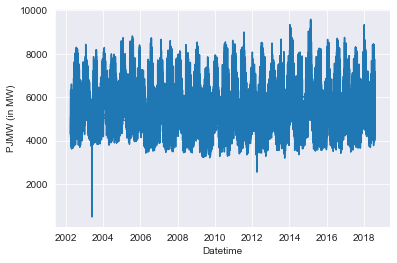

In [9]:
plt.plot(df['PJMW_MW'])
plt.xlabel('Datetime')
plt.ylabel('PJMW (in MW)')

<Axes: xlabel='PJMW_MW', ylabel='Density'>

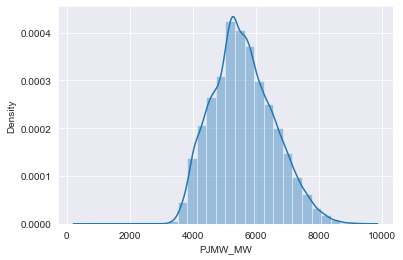

In [10]:
sns.distplot(df['PJMW_MW'], bins=30)

<Axes: xlabel='PJMW_MW', ylabel='Count'>

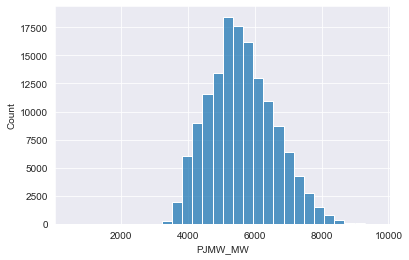

In [11]:
sns.histplot(df['PJMW_MW'], bins=30)

### From histogram we can say that the data is normally distributed

<Axes: xlabel='Datetime', ylabel='Density'>

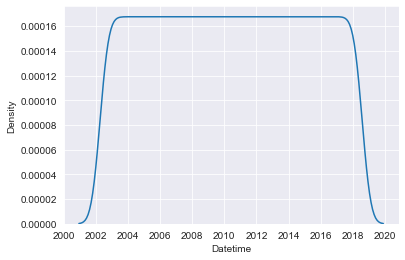

In [12]:
sns.kdeplot(df.index)

<Axes: xlabel='PJMW_MW'>

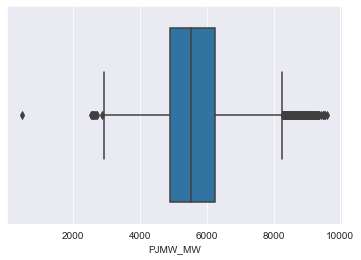

In [13]:
sns.boxplot(df['PJMW_MW'])

<Axes: xlabel='Datetime', ylabel='PJMW_MW'>

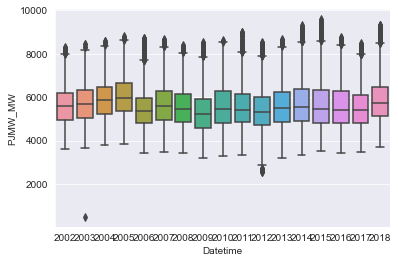

In [14]:
sns.boxplot(x=df.index.year, y=df['PJMW_MW'])

<Axes: xlabel='Datetime', ylabel='PJMW_MW'>

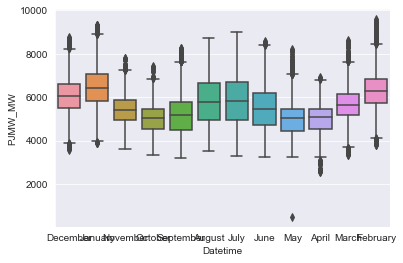

In [15]:
sns.boxplot(x=df.index.month_name(), y=df['PJMW_MW'])

<Axes: xlabel='Datetime', ylabel='PJMW_MW'>

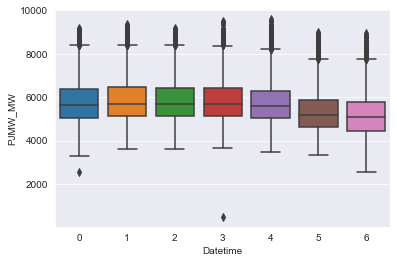

In [16]:
sns.boxplot(x=df.index.day_of_week, y=df['PJMW_MW'])

<Axes: xlabel='Datetime', ylabel='PJMW_MW'>

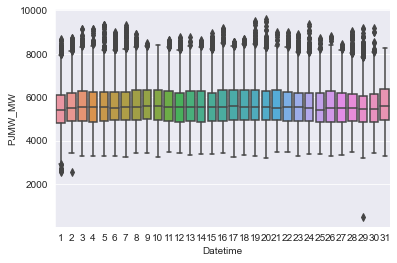

In [17]:
sns.boxplot(x=df.index.day, y=df['PJMW_MW'])

### In above graph instead of using month we use month_name() because our datetime series starts form 'December' instead of 'January' and it gives numbers according to datetime series sequence ie. December will be numbered as 1 instead of 12

In [18]:
# Total yearly usage
total_yearly_usage = df.groupby(df.index.year)["PJMW_MW"].sum()
total_yearly_usage

Datetime
2002    37086112.0
2003    49926102.0
2004    51520627.0
2005    52884360.0
2006    47516081.0
2007    49354805.0
2008    48565624.0
2009    46334702.0
2010    48802983.0
2011    48253429.0
2012    47378985.0
2013    48666311.0
2014    49549487.0
2015    49239834.0
2016    48996533.0
2017    48181615.0
2018    30036137.0
Name: PJMW_MW, dtype: float64

Text(0, 0.5, 'PJMW (in MW)')

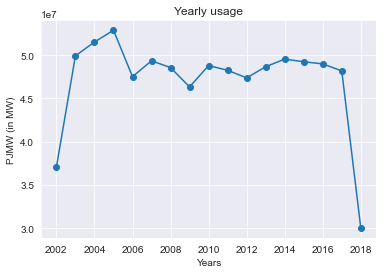

In [19]:
total_yearly_usage.plot(marker='o', title='Yearly usage')
plt.xlabel('Years')
plt.ylabel('PJMW (in MW)')

In [20]:
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)

Text(0.5, 1.0, 'Total yearly usage')

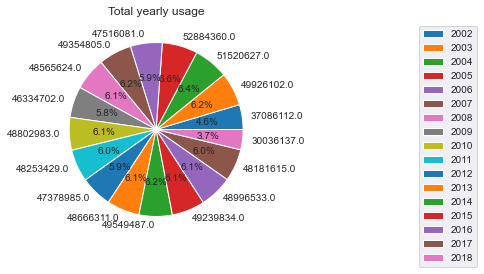

In [21]:
plt.pie(total_yearly_usage, labels=total_yearly_usage, autopct = lambda pct: func(pct, total_yearly_usage))
plt.legend(total_yearly_usage.index, bbox_to_anchor=(2, 1))
plt.title('Total yearly usage')

In [22]:
# Monthly usage across years
monthly_usage_across_years = pd.pivot_table(df, values='PJMW_MW', columns=df.index.month_name(), index=df.index.year)
monthly_usage_across_years

Datetime,April,August,December,February,January,July,June,March,May,November,October,September
Datetime,,,,,,,,,,,,
2002,5171.318942,6063.909946,6154.673387,NaN,NaN,6097.877688,5685.681944,NaN,5085.094086,5582.980556,5311.936743,5419.641667
2003,5232.509040,6024.669355,6266.799731,6402.547619,6586.263441,5820.044355,5398.618056,5641.485215,5026.915323,5445.623611,5275.403769,5307.640278
2004,5426.936022,5910.219086,6395.706989,6393.234195,6828.658602,5956.732527,5716.779167,5777.657258,5511.560484,5602.116667,5313.002692,5562.062500
2005,5380.983310,6471.497312,6563.709677,6433.568452,6598.818548,6391.413978,6156.520833,6218.537634,5253.323925,5779.622222,5437.663526,5777.605556
2006,4788.084840,6017.083333,5692.561828,6041.986607,5753.059140,5892.213710,5316.781944,5541.309140,4875.614247,5260.411111,5027.837147,4910.723611
2007,5215.961111,6079.646505,6046.346774,6725.876488,6038.096774,5560.966398,5508.394444,5599.539704,5034.049731,5433.479833,5105.029570,5349.212500
2008,4959.263889,5458.784946,6015.278226,6279.462644,6268.275538,5776.416667,5562.731944,5627.838493,4840.682796,5457.931850,4986.365591,5144.813889
2009,4849.751389,5540.622312,6031.521505,6022.083333,6550.642473,5105.278226,5059.287500,5337.670256,4572.251344,4955.984701,4733.576613,4748.466667
2010,4738.938889,5838.908602,6477.201884,6378.889881,6406.479839,6035.850806,5689.716667,5323.368775,4962.254032,5256.499305,4732.794355,5064.072222


Text(0, 0.5, 'PJMW (in MW)')

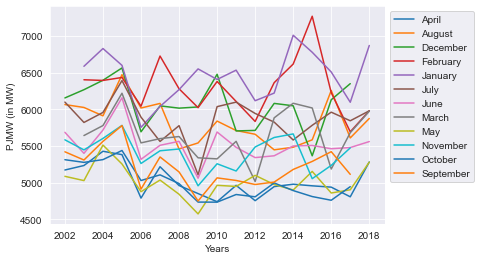

In [23]:
monthly_usage_across_years.plot()
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Years')
plt.ylabel('PJMW (in MW)')

In [24]:
# Total monthly usage 
total_monthly_usage = monthly_usage_across_years.sum(axis=0, skipna=True)
total_monthly_usage

Datetime
April         85380.725210
August        99025.193713
December      97031.454572
February     100765.172157
January      103162.684140
July          99646.130376
June          93784.852778
March         90464.800822
May           85269.377688
November      86457.706132
October       79964.126134
September     83293.952778
dtype: float64

Text(0, 0.5, 'PJMW (in MW)')

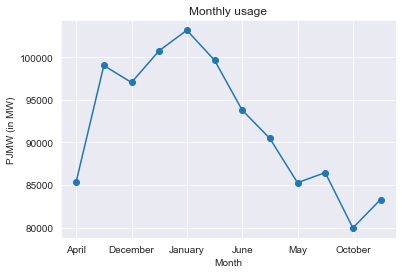

In [25]:
total_monthly_usage.plot(marker='o', title='Monthly usage')
plt.xlabel('Month')
plt.ylabel('PJMW (in MW)')

Text(0.5, 1.0, 'Total monthly usage')

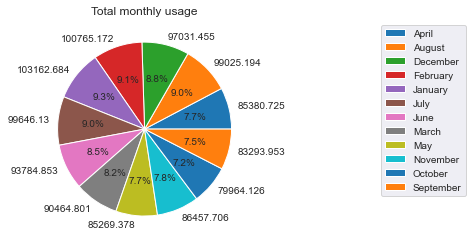

In [26]:
plt.pie(total_monthly_usage, labels=total_monthly_usage.round(3), autopct = lambda pct: func(pct, total_monthly_usage))
plt.legend(total_monthly_usage.index, bbox_to_anchor=(2, 1))
plt.title('Total monthly usage')

In [27]:
# Quarterly usage across years
quarterly_usage_over_years = pd.pivot_table(df, values='PJMW_MW', columns=df.index.quarter, index=df.index.year)
quarterly_usage_over_years

Datetime,1,2,3,4
Datetime,,,,
2002,NaN,5311.644363,5865.268116,5684.454916
2003,6203.683796,5217.225836,5721.905797,5665.144087
2004,6331.863553,5551.373798,5812.362772,5772.311282
2005,6416.421759,5593.263857,6218.243659,5928.822836
2006,5770.011574,4992.291800,5614.238225,5327.795650
2007,6101.246410,5250.397894,5666.688859,5529.359311
2008,6053.864865,5117.813645,5463.431159,5486.849116
2009,5968.692450,4824.296245,5135.618659,5243.582238
2010,6025.149606,5128.456502,5652.605525,5491.016772


Text(0, 0.5, 'PJMW (in MW)')

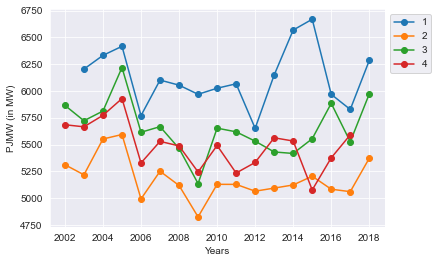

In [28]:
quarterly_usage_over_years.plot(marker='o')
plt.legend(quarterly_usage_over_years, bbox_to_anchor=(1, 1))
plt.xlabel('Years')
plt.ylabel('PJMW (in MW)')

In [29]:
# Total quarterly usage
total_quarterly_usage = quarterly_usage_over_years.sum(axis=0, skipna=True)
total_quarterly_usage

Datetime
1    98053.962873
2    88113.754324
3    96082.977511
4    87833.177033
dtype: float64

Text(0, 0.5, 'PJMW (in MW)')

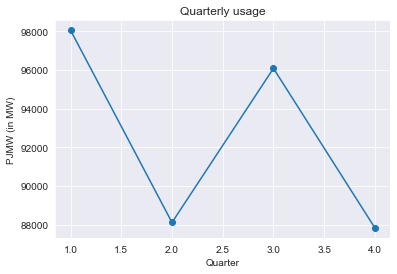

In [30]:
total_quarterly_usage.plot(marker='o', title='Quarterly usage')
plt.xlabel('Quarter')
plt.ylabel('PJMW (in MW)')

Text(0.5, 1.0, 'Total quarterly usage')

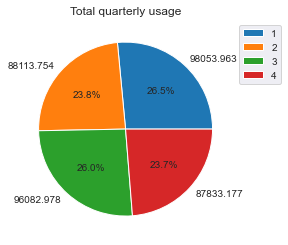

In [31]:
plt.pie(total_quarterly_usage, labels=total_quarterly_usage.round(3), autopct = lambda pct: func(pct, total_quarterly_usage))
plt.legend(total_quarterly_usage.index, bbox_to_anchor=(1, 1))
plt.title('Total quarterly usage')

Text(0.5, 0, 'PJMW (in MW)')

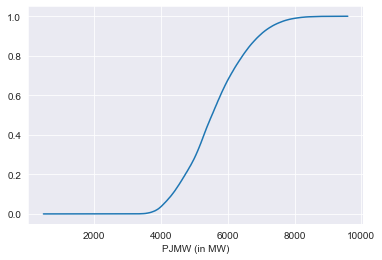

In [32]:
# Plotting of Empirical Cumulative Distribution Function
from statsmodels.distributions.empirical_distribution import ECDF
cdf = ECDF(df['PJMW_MW'])
plt.plot(cdf.x, cdf.y)
plt.xlabel('PJMW (in MW)')

### From above graph we ca see that around 60% of PJMW (power usage) is 5600 MW or less

In [33]:
# Average usage per year
average_year = df.groupby(df.index.year)["PJMW_MW"].mean()
average_year

Datetime
2002    5621.663180
2003    5700.628226
2004    5866.616602
2005    6038.406029
2006    5425.448847
2007    5635.396780
2008    5530.132544
2009    5290.557433
2010    5573.025351
2011    5509.640215
2012    5395.010818
2013    5556.783626
2014    5656.334132
2015    5620.985616
2016    5577.929531
2017    5500.184361
2018    5848.157516
Name: PJMW_MW, dtype: float64

Text(0, 0.5, 'PJMW (in MW)')

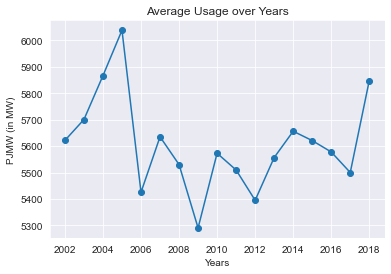

In [34]:
average_year.plot(marker='o', title='Average Usage over Years')
plt.xlabel('Years')
plt.ylabel('PJMW (in MW)')

In [35]:
# Average usage per month
average_month = df.groupby(df.index.month_name())["PJMW_MW"].mean()
average_month

Datetime
April        5022.310855
August       5822.142809
December     6064.431236
February     6296.808813
January      6447.667759
July         5861.537081
June         5516.756046
March        5654.097376
May          5015.845746
November     5403.630372
October      4997.642155
September    5205.872049
Name: PJMW_MW, dtype: float64

Text(0, 0.5, 'PJMW (in MW)')

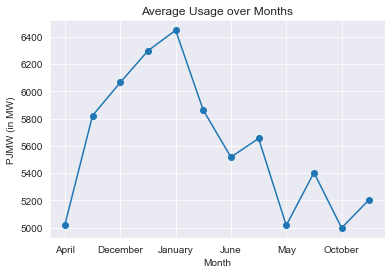

In [36]:
average_month.plot(marker='o', title='Average Usage over Months')
plt.xlabel('Month')
plt.ylabel('PJMW (in MW)')

In [37]:
# Percentage change of power usage per year 
pct_change_year = df.groupby(df.index.year)["PJMW_MW"].sum().pct_change()
pct_change_year

Datetime
2002         NaN
2003    0.346221
2004    0.031938
2005    0.026470
2006   -0.101510
2007    0.038697
2008   -0.015990
2009   -0.045936
2010    0.053271
2011   -0.011261
2012   -0.018122
2013    0.027171
2014    0.018148
2015   -0.006249
2016   -0.004941
2017   -0.016632
2018   -0.376606
Name: PJMW_MW, dtype: float64

Text(0, 0.5, 'Percentage')

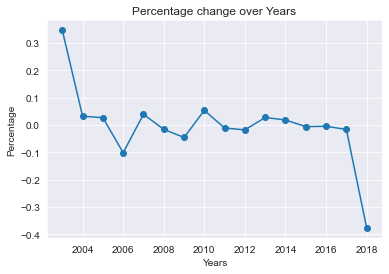

In [38]:
pct_change_year.plot(marker='o', title='Percentage change over Years')
plt.xlabel('Years')
plt.ylabel('Percentage')

In [39]:
# Percentage change of power usage per month
pct_change_month = df.groupby(df.index.month_name())["PJMW_MW"].sum().pct_change()
pct_change_month

Datetime
April             NaN
August       0.132629
December     0.037258
February    -0.053711
January      0.123635
July        -0.034087
June        -0.089182
March       -0.004244
May         -0.056487
November    -0.019023
October     -0.044456
September    0.008487
Name: PJMW_MW, dtype: float64

Text(0, 0.5, 'Percentage')

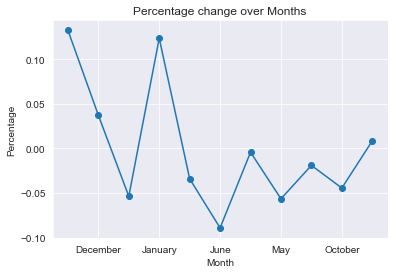

In [40]:
pct_change_month.plot(marker='o', title='Percentage change over Months')
plt.xlabel('Month')
plt.ylabel('Percentage')

### Decomposing the Time Series and plotting the different components

#### Assuming Additive Decomposition

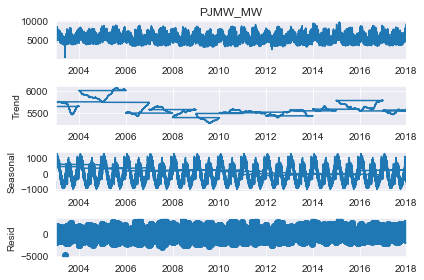

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
add_decomposition = seasonal_decompose(df['PJMW_MW'], model='additive', period=8760)
add_decomposition.plot();

#### Assuming Multiplicative Decomposition

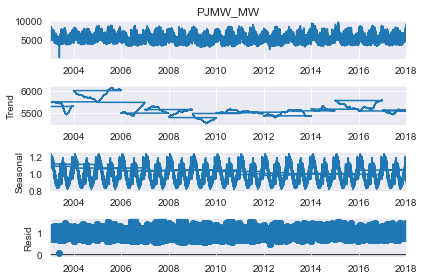

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose
mul_decomposition = seasonal_decompose(df['PJMW_MW'], model='multiplicative', period=8760)
mul_decomposition.plot();

#### In the multiplicative model, We observe that the trend and seasonality are clearly separated and the scale of noise is small. In the additive model, there are outliers present in the residual. So the series is multiplicative.

In [43]:
from statsmodels.tsa.stattools import adfuller

In [44]:
p = adfuller(df['PJMW_MW'])[1]
p

0.0

#### According the p-value, the dataset is stationary as the p value is less than alpha value (0.05).

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

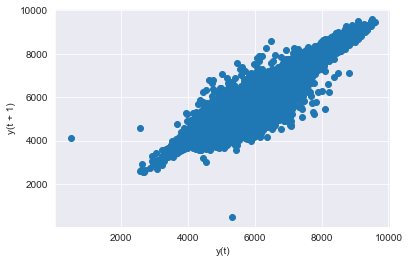

In [45]:
# Lag plot
pd.plotting.lag_plot(df['PJMW_MW'], lag=1)

In [46]:
# Original, moving average and std plot
df_ma = df['PJMW_MW'].rolling(window=8760).mean()
df_ma.dropna(inplace=True)
df_std = df['PJMW_MW'].rolling(window=8760).std()
df_std.dropna(inplace=True)

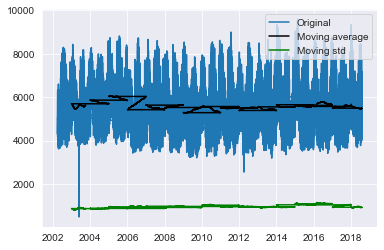

In [47]:
plt.plot(df['PJMW_MW'])
plt.plot(df_ma, color='black')
plt.plot(df_std, color='green')
plt.legend(labels=['Original', 'Moving average', 'Moving std'], loc='upper right')

In [48]:
df.shape

(143206, 4)

In [49]:
# Data for models
df['t'] = np.arange(1,143207)
df['t_square'] = np.square(df['t'])
df['log_PJMW'] = np.log(df['PJMW_MW'])
df

,PJMW_MW,Years,Season,Hours,t,t_square,log_PJMW
Datetime,,,,,,,
2002-12-31 01:00:00,5077.0,2002,Winter,1,1,1,8.532476
2002-12-31 02:00:00,4939.0,2002,Winter,2,2,4,8.504918
2002-12-31 03:00:00,4885.0,2002,Winter,3,3,9,8.493925
2002-12-31 04:00:00,4857.0,2002,Winter,4,4,16,8.488176
2002-12-31 05:00:00,4930.0,2002,Winter,5,5,25,8.503094
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,8401.0,2018,Winter,20,143202,-968023676,9.036106
2018-01-01 21:00:00,8373.0,2018,Winter,21,143203,-967737271,9.032768
2018-01-01 22:00:00,8238.0,2018,Winter,22,143204,-967450864,9.016513


### Spliting of data

In [50]:
df[df['Years'] == 2018]

,PJMW_MW,Years,Season,Hours,t,t_square,log_PJMW
Datetime,,,,,,,
2018-01-01 00:00:00,7612.0,2018,Winter,0,129335,-452326959,8.937481
2018-08-02 01:00:00,5100.0,2018,Summer,1,138072,1884008000,8.536996
2018-08-02 02:00:00,4840.0,2018,Summer,2,138073,1884284145,8.484670
2018-08-02 03:00:00,4745.0,2018,Summer,3,138074,1884560292,8.464847
2018-08-02 04:00:00,4572.0,2018,Summer,4,138075,1884836441,8.427706
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,8401.0,2018,Winter,20,143202,-968023676,9.036106
2018-01-01 21:00:00,8373.0,2018,Winter,21,143203,-967737271,9.032768
2018-01-01 22:00:00,8238.0,2018,Winter,22,143204,-967450864,9.016513


In [51]:
143207-5136

138071

In [52]:
train = df.head(138071)
test = df.tail(5135)

## Model building

In [53]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

### Arima model

In [54]:
order = auto_arima(df['PJMW_MW'], start_p=1, start_q=1, test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

In [55]:
order

ARIMA(order=(3, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

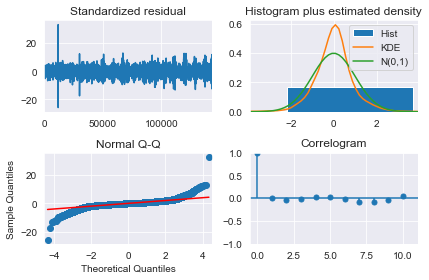

In [56]:
order.plot_diagnostics();
plt.tight_layout()

In [57]:
arima = ARIMA(train['PJMW_MW'], order=(3, 0, 2)).fit()
arima_pred = pd.Series(arima.predict(start=test.t[0], end=test.t[-1]))
rmse_arima = np.sqrt(mean_squared_error(test['PJMW_MW'], arima_pred))
rmse_arima

C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-

1051.295352135866

### Sarima model

In [70]:
# Seasonal - fit stepwise auto-ARIMA
order1 = auto_arima(df['PJMW_MW'], start_p=1, start_q=1, test='adf', max_p=3, max_q=3, 
                         m=1, #1 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

In [71]:
order1

ARIMA(order=(3, 0, 3), scoring_args={}, suppress_warnings=True)

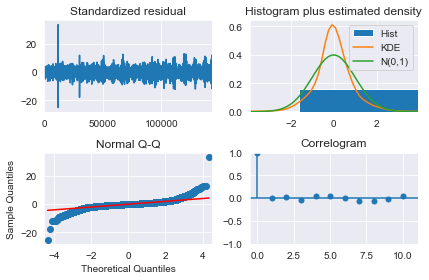

In [72]:
order1.plot_diagnostics();
plt.tight_layout()

In [73]:
sarima = ARIMA(train['PJMW_MW'], order=(3, 0, 3)).fit()
sarima_pred = pd.Series(sarima.predict(start=test.t[0], end=test.t[-1]))
rmse_sarima = np.sqrt(mean_squared_error(test['PJMW_MW'], sarima_pred))
rmse_sarima

C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-

1046.8603529645818

### Model based Forecasting Methods

In [60]:
df.head(2)

,PJMW_MW,Years,Season,Hours,t,t_square,log_PJMW
Datetime,,,,,,,
2002-12-31 01:00:00,5077.0,2002,Winter,1,1,1,8.532476
2002-12-31 02:00:00,4939.0,2002,Winter,2,2,4,8.504918


#### Linear model

In [61]:
linear = smf.ols('PJMW_MW~t', data=train).fit()
pred_linear = pd.Series(linear.predict((test[['t']])))
rmse_linear = np.sqrt(mean_squared_error(test['PJMW_MW'], pred_linear))
rmse_linear

1077.6063180481474

#### Exponential model

In [62]:
exp = smf.ols('log_PJMW~t', data=train).fit()
pred_exp = pd.Series(exp.predict(test[['t']]))
rmse_exp = np.sqrt(mean_squared_error(test['PJMW_MW'], pred_exp))
rmse_exp

5926.915942263731

#### Quadratic model

In [63]:
quad = smf.ols('PJMW_MW~t+t_square',data=train).fit()
pred_quad = pd.Series(quad.predict(test[['t', 't_square']]))
rmse_quad = np.sqrt(mean_squared_error(test['PJMW_MW'], pred_quad))
rmse_quad

1081.98019462208

In [64]:
from statsmodels.tsa.holtwinters import Holt, SimpleExpSmoothing, ExponentialSmoothing

In [65]:
test

,PJMW_MW,Years,Season,Hours,t,t_square,log_PJMW
Datetime,,,,,,,
2018-08-02 01:00:00,5100.0,2018,Summer,1,138072,1884008000,8.536996
2018-08-02 02:00:00,4840.0,2018,Summer,2,138073,1884284145,8.484670
2018-08-02 03:00:00,4745.0,2018,Summer,3,138074,1884560292,8.464847
2018-08-02 04:00:00,4572.0,2018,Summer,4,138075,1884836441,8.427706
2018-08-02 05:00:00,4594.0,2018,Summer,5,138076,1885112592,8.432506
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,8401.0,2018,Winter,20,143202,-968023676,9.036106
2018-01-01 21:00:00,8373.0,2018,Winter,21,143203,-967737271,9.032768
2018-01-01 22:00:00,8238.0,2018,Winter,22,143204,-967450864,9.016513


### Simple Exponential Method

In [66]:
ses_model = SimpleExpSmoothing(train['PJMW_MW']).fit()
pred_ses = ses_model.predict(start=test.t[0], end=test.t[-1])
rmse_ses = np.sqrt(mean_squared_error(test['PJMW_MW'], pred_ses))
rmse_ses

C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


1308.8354630701072

### Holt method

In [67]:
holt_model = Holt(train['PJMW_MW']).fit()
pred_holt = holt_model.predict(start=test.t[0], end=test.t[-1])
rmse_holt = np.sqrt(mean_squared_error(test['PJMW_MW'], pred_holt))
rmse_holt

C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


805011.6442961129

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [68]:
holt_mul_sea_add_tr = ExponentialSmoothing(train["PJMW_MW"],seasonal="mul",trend="add", seasonal_periods=365).fit()
pred_holt_mul_sea_add_tr = holt_mul_sea_add_tr.predict(start=test.t[0], end=test.t[-1])
rmse_holt_mul_sea_add_tr = np.sqrt(mean_squared_error(test['PJMW_MW'], pred_holt_mul_sea_add_tr))
rmse_holt_mul_sea_add_tr

C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


544187.7371805651

### Holts winter exponential smoothing with additive seasonality and additive trend

In [69]:
holt_add_sea_add_tr = ExponentialSmoothing(train["PJMW_MW"],seasonal="add",trend="add", seasonal_periods=365).fit()
pred_holt_add_sea_add_tr = holt_add_sea_add_tr.predict(start=test.t[0], end=test.t[-1])
rmse_holt_add_sea_add_tr = np.sqrt(mean_squared_error(test['PJMW_MW'], pred_holt_add_sea_add_tr))
rmse_holt_add_sea_add_tr

C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


489601.8149423828

### Model - RMSE value data

In [77]:
data = {
    'Model' : ['Linear model', 'Exponential model', 'Quadratic model', 'Arima model', 'Sarima model',
               'Simple Exponential Method', 'Holt model', 
               'Holts winter exponential smoothing model with multiplicative seasonality and additive trend', 
               'Holts winter exponential smoothing model with additive seasonality and additive trend'],
    'RMSE Values' : [rmse_linear, rmse_exp, rmse_quad, rmse_arima, rmse_sarima, rmse_ses, rmse_holt, 
                     rmse_holt_mul_sea_add_tr, rmse_holt_add_sea_add_tr]
}
RMSE = pd.DataFrame(data)
RMSE

,Model,RMSE Values
0,Linear model,1077.606318
1,Exponential model,5926.915942
2,Quadratic model,1081.980195
3,Arima model,1051.295352
4,Sarima model,1046.860353
5,Simple Exponential Method,1308.835463
6,Holt model,805011.644296
7,Holts winter exponential smoothing model with ...,544187.737181
8,Holts winter exponential smoothing model with ...,489601.814942
